In [1]:
# Standard
import logging

# Third party
import numpy as np
import rdkit
from rdkit import RDLogger
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader

# GT-PyG
from gt_pyg.data.utils import (
    get_tensor_data, 
    get_node_dim, 
    get_edge_dim, 
    get_train_valid_test_data
)
from gt_pyg.nn.model import GraphTransformerNet
import weightwatcher as ww

# Turn off majority of RDKit warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


# Set a random seed for a reproducibility purposes
torch.manual_seed(192837465)

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Log the used versions of RDkit and torch
print(f'Numpy version: {np.__version__}')
print(f'Rdkit version: {rdkit.__version__}')
print(f'Torch version: {torch.__version__}')

/Users/pawel/anaconda3/envs/gt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch is available but CUDA is not. Defaulting to SciPy for SVD


Numpy version: 1.21.6
Rdkit version: 2022.09.5
Torch version: 1.13.1


## Get the ADME@TDC data

**Note**: To use the code below, make sure that the chosen endpoint is a regression task.

In [2]:
from tdc import utils
names = utils.retrieve_benchmark_names('ADMET_Group')
output = "\n".join([f"{index}. {name}" for index, name in enumerate(names, start=1)])
print("Available endpoints:\n\n" + output)

Available endpoints:

1. caco2_wang
2. hia_hou
3. pgp_broccatelli
4. bioavailability_ma
5. lipophilicity_astrazeneca
6. solubility_aqsoldb
7. bbb_martins
8. ppbr_az
9. vdss_lombardo
10. cyp2d6_veith
11. cyp3a4_veith
12. cyp2c9_veith
13. cyp2d6_substrate_carbonmangels
14. cyp3a4_substrate_carbonmangels
15. cyp2c9_substrate_carbonmangels
16. half_life_obach
17. clearance_microsome_az
18. clearance_hepatocyte_az
19. herg
20. ames
21. dili
22. ld50_zhu


Regression endpoints with MAE metric:
1. caco2_wang (Best: 0.285 ± 0.005)
2. lipophilicity_astrazeneca (Best: 0.535 ± 0.012)
3. solubility_aqsoldb (Best: 0.776 ± 0.008)
4. ppbr_az (Best: 9.185 ± 0.000)
5. ld50_zhu (Best: 0.588 ± 0.005)

In [3]:
PE_DIM = 6
(tr, va, te) = get_train_valid_test_data('lipophilicity_astrazeneca', min_num_atoms=0)
tr_dataset = get_tensor_data(tr.Drug.to_list(), tr.Y.to_list(), pe_dim=PE_DIM)
va_dataset = get_tensor_data(va.Drug.to_list(), va.Y.to_list(), pe_dim=PE_DIM)
te_dataset = get_tensor_data(te.Drug.to_list(), te.Y.to_list(), pe_dim=PE_DIM)
NODE_DIM = get_node_dim()
EDGE_DIM = get_edge_dim()

print(f'Number of training examples: {len(tr_dataset)}')
print(f'Number of validation examples: {len(va_dataset)}')
print(f'Number of test examples: {len(te_dataset)}')

train_loader = DataLoader(tr_dataset, batch_size=128)
val_loader = DataLoader(va_dataset, batch_size=512)
test_loader = DataLoader(te_dataset, batch_size=512)

Found local copy...
Loading...
Done!


Number of training examples: 2940
Number of validation examples: 420
Number of test examples: 840


## Train and eval the GT model

### Auxiliary functions

In [4]:
def train(epoch, loss_func, warmup_epochs=5):
    model.train()
    
    if epoch > warmup_epochs:
        corrections = get_correction_factor(model, optimizer)
        for idx, val in enumerate(corrections):
            optimizer.param_groups[idx]['lr'] = val * optimizer.param_groups[idx]['base_lr']
            #print(idx, val, optimizer.param_groups[idx]['base_lr'], 
            #      optimizer.param_groups[idx]['lr'], optimizer.param_groups[idx]['name'])
    
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=False)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
                
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader, loss_func):
    model.eval()

    total_error = 0
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
        total_error += loss_func(out.squeeze(), data.y).item()
    return total_error / len(loader.dataset)

train_loss = nn.L1Loss(reduction='mean')
test_loss = nn.L1Loss(reduction='sum')


### Slighlty optimized Graph Transformer architecture

1. `gelu` activation is used instead of `relu`
2. Multiaggregator used for global pooling
3. Multiaggregator used for message passing

Number of params 873k instead of 701k

In [5]:
def get_ww_statistic(model, statistic='alpha'):
    """
        {'log_norm': ...,
        'alpha': ...,
        'alpha_weighted': ...,
        'log_alpha_norm': ...,
        'log_spectral_norm': ...,
        'stable_rank': ...}
    """
    watcher = ww.WeightWatcher(model=model)
    details = watcher.analyze(plot=False)
    summary = watcher.get_summary(details)
    return summary[statistic]

In [19]:
def ww_active_layer_idx(model):
    watcher = ww.WeightWatcher(model=model)
    details = watcher.analyze(plot=False)
    return details['layer_id'].to_list()

def ww_active_layer_alpha(model):
    watcher = ww.WeightWatcher(model=model)
    details = watcher.analyze(plot=False)
    return details['alpha'].to_list()

def ww_active_layers_data(model):
    indices = ww_active_layer_idx(model)
    alphas = ww_active_layer_alpha(model)
    
    names = []
    layer_alpha = []
    for (idx, module) in enumerate(model.named_modules()):
        if idx in indices:
            names.append(module[0])
            layer_alpha.append(alphas[indices.index(idx)])
            
    assert len(names) == len(indices)
    return (names,layer_alpha)

def prepare_params(model, base_lr):
    params = []
    for (name, p) in model.named_parameters():
        params.append({'params': p, 'lr': base_lr, 'name': name, 'base_lr':base_lr})

    return params

def get_correction_factor(model, opt):
    (ln, avals) = ww_active_layers_data(model)
    
    corrections = []
    for pg in opt.param_groups:
        name = '.'.join(pg['name'].split('.')[:-1])
        if name in ln:
            alpha = avals[ln.index(name)]
            if alpha > 2.0 and alpha < 3.0:
                corr = 0.1
            if alpha > 3.0 and alpha < 4.0:
                corr = 0.2
            if alpha > 4.0 and alpha < 5.0:
                corr = 0.3
            if alpha > 5.0 and alpha < 6.0:
                corr = 0.4
            if alpha < 2.0:
                corr = 1.0
            if alpha > 6.0:
                corr = 1.0 + (alpha - 6.0)
            corrections.append(corr)
            
        else:
            corrections.append(1.0)
            
    return corrections

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=4, 
                            hidden_dim=128,
                            num_heads=8,
                            norm='bn',
                            gt_aggregators=['sum', 'mean'],
                            aggregators=['sum','mean','max', 'std'],
                            dropout=0.1,
                            act='gelu').to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model = torch_geometric.compile(model) 

lr = 0.001
params = prepare_params(model, lr)
optimizer = torch.optim.AdamW(params)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10,
                              min_lr=0.00001)

print(model)
print(f"Number of params: {model.num_parameters()//1000} k")


best_epoch = 0
best_validation_loss = np.inf
test_set_mae = np.inf

epochs_list = []
train_loss_list = []
valid_loss_list = []
test_loss_list = []
ww_list = []

for epoch in range(1, 101):
    tr_loss = train(epoch, loss_func=train_loss, warmup_epochs=1)
    va_loss = test(val_loader, loss_func=test_loss)
    te_loss = test(test_loader, loss_func=test_loss)
    scheduler.step(va_loss)
    print(f'Epoch: {epoch:02d}, Loss: {tr_loss:.4f}, Val: {va_loss:.4f}, '
          f'Test: {te_loss:.4f}')
    if va_loss < best_validation_loss:
        best_epoch = epoch
        best_validation_loss = va_loss
        test_set_mae = te_loss
    
    epochs_list.append(epoch)
    train_loss_list.append(tr_loss)
    valid_loss_list.append(va_loss)
    test_loss_list.append(te_loss)
    ww_list.append(get_ww_statistic(model))
    
print("\nModel's performance on the test set\n"
        "===================================\n"
        f'MAE={test_set_mae}\n'
        f'Epoch={best_epoch}')

GraphTransformerNet(
  (node_emb): Linear(in_features=76, out_features=128, bias=True)
  (edge_emb): Linear(in_features=10, out_features=128, bias=True)
  (pe_emb): Linear(in_features=6, out_features=128, bias=True)
  (gt_layers): ModuleList(
    (0): GTConv(128, 128, heads=8, aggrs: sum,mean)
    (1): GTConv(128, 128, heads=8, aggrs: sum,mean)
    (2): GTConv(128, 128, heads=8, aggrs: sum,mean)
    (3): GTConv(128, 128, heads=8, aggrs: sum,mean)
  )
  (global_pool): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
    MaxAggregation(),
    StdAggregation(),
  ], mode=cat)
  (mu_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (log_var_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=

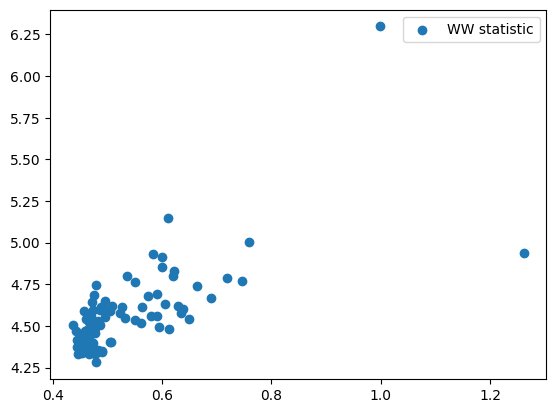

In [21]:
plt.scatter(test_loss_list, ww_list, label='WW statistic')
plt.legend(loc=0)

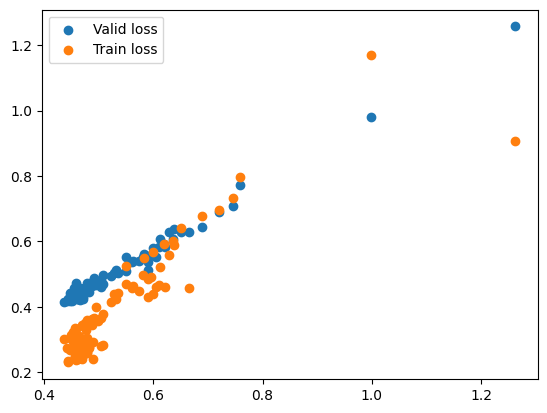

In [22]:
plt.scatter(test_loss_list, valid_loss_list, label='Valid loss')
plt.scatter(test_loss_list, train_loss_list, label='Train loss')
plt.legend(loc=0)

In [23]:
test_loss_list[np.argmin(ww_list)]

0.47957391284760975

In [24]:
test_loss_list[np.argmin(valid_loss_list)]

0.4373631795247396

In [25]:
test_loss_list[np.argmin(train_loss_list)]

0.44479488191150485

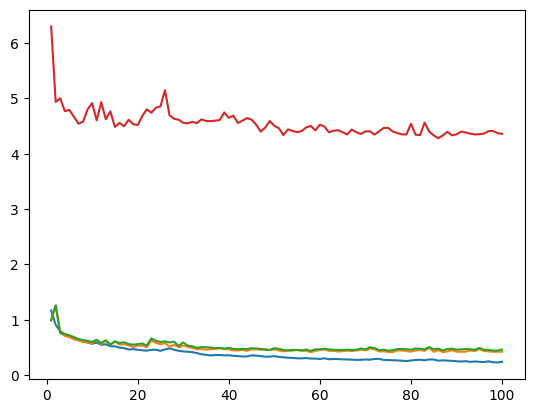

In [26]:
plt.plot(epochs_list, train_loss_list)
plt.plot(epochs_list, valid_loss_list)
plt.plot(epochs_list, test_loss_list)
plt.plot(epochs_list, ww_list)

In [27]:
watcher = ww.WeightWatcher(model=model)
details = watcher.analyze(plot=False)
details

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,rf,sigma,spectral_norm,stable_rank,status,sv_max,warning,weak_rank_loss,xmax,xmin
0,1,Linear,0.074264,76,128,1.684211,4.857847,4.467737,0.916526,True,...,1,1.163185,8.311798,13.413714,success,2.883019,,0,8.311798,2.874970
1,2,Linear,0.204901,10,128,12.800000,3.806222,1.844699,0.975120,True,...,1,0.992149,3.052485,6.325601,success,1.747136,,0,3.052485,1.467839
2,11,Linear,0.068547,128,128,1.000000,4.812073,4.290580,0.888195,True,...,1,0.984273,7.791630,18.026660,success,2.791349,,0,7.791630,2.649227
3,12,Linear,0.063068,128,128,1.000000,4.168486,4.082551,0.878196,True,...,1,0.792122,9.536402,15.442621,success,3.088107,,0,9.536402,2.671390
4,13,Linear,0.122019,128,128,1.000000,5.538202,3.262524,0.894940,True,...,1,1.069664,3.882348,32.315618,success,1.970368,,0,3.882348,2.310880
5,14,Linear,0.070470,128,256,2.000000,4.401672,3.942632,0.936330,True,...,1,0.780397,7.865248,24.997232,success,2.804505,,0,7.865248,2.797105
6,15,Linear,0.058077,128,128,1.000000,4.394922,4.745464,0.875831,True,...,1,0.823390,12.016019,11.772197,success,3.466413,,0,12.016019,2.490113
7,16,Linear,0.129159,128,128,1.000000,5.753475,3.818934,0.893470,True,...,1,1.188369,4.610640,29.624841,success,2.147240,,0,4.610640,2.670856
8,19,Linear,0.064987,128,128,1.000000,3.351539,1.481710,0.875355,True,...,1,0.461175,2.767569,17.622437,success,1.663601,,0,2.767569,0.655344
9,22,Linear,0.069532,128,128,1.000000,2.779242,2.537375,0.821736,True,...,1,0.319561,8.184155,7.765956,success,2.860796,,1,8.184155,0.636073


In [28]:
watcher.get_summary(details)

{'log_norm': 1.9564941470926265,
 'alpha': 4.3592625022569935,
 'alpha_weighted': 2.71039528336958,
 'log_alpha_norm': 3.200391359296851,
 'log_spectral_norm': 0.6315924272155928,
 'stable_rank': 23.235040500542137}